# Bezier Curve

In [2]:
%load_ext autoreload

## CurveSegment

0.4902341936249286


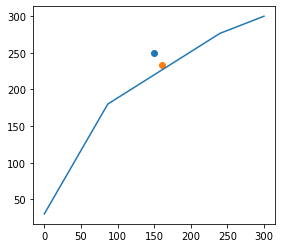

In [6]:
%autoreload
import numpy as np
from bezierpath import Curve

controlPoints = np.array([(0,30), (0,200), (340, 320), (300, 300)])
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_aspect(1)

P = (150, 250)
ax.scatter(P[0], P[1])

curve = Curve(*controlPoints)
points = np.array([curve.getPoint(t) for t in np.linspace(0,1,4)])
ax.plot(points[:,0], points[:,1])

nearestTime = curve.getNearestTime(P)
print(nearestTime)
nearestPoint = curve.getPoint(nearestTime)
ax.scatter(nearestPoint[0], nearestPoint[1])

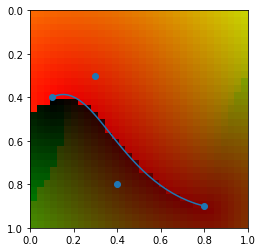

In [62]:
%autoreload
from numba import jit
import math
from bezierpath import Curve

@jit(nopython=True)
def fillCurveCoord(img, curve):
    height, width, channels = img.shape

    for i in range(height*width):
        x = i%width
        y = i//width

        u, v = curve.getuv(x/width, y/height)
        img[y,x] = np.array([u, v, 0.0])
    
    return img

# Plot
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
cp = np.array([
 (0.1, 0.4),
 (0.3, 0.3),
 (0.4, 0.8),
 (0.8, 0.9)
])
plt.scatter(cp[:,0], cp[:,1])

curve = Curve(*cp)
points = np.array( [curve.getPoint(t) for t in np.linspace(0,1,32)] )
plt.plot(points[:,0], points[:, 1])

img = np.zeros( (32, 32, 3), dtype=np.float32 )
img = fillCurveCoord(img, curve)
plt.imshow(img, extent=(0,1,1,0))

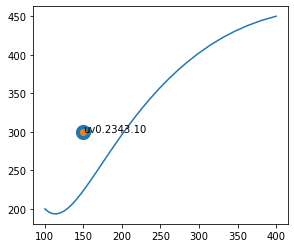

In [99]:
%autoreload
from bezierpath import Curve

fig, ax = plt.subplots()
ax.set_aspect(1)
cp = np.array([(100,200), (150,150), (200, 400), (400, 450)])
curve = Curve(*cp)
points = np.array( [curve.getPoint(t) for t in np.linspace(0,1,32)] )
ax.plot(points[:,0], points[:,1])

P = (150, 300)
ax.scatter(P[0], P[1], s=200)
u, v = curve.getuv(P[0], P[1])
ax.annotate( "uv{:.2f}{:.2f}".format(u, v), P )

x, y = curve.getxy(u, v)
ax.scatter(x, y)


2.9929988384246826


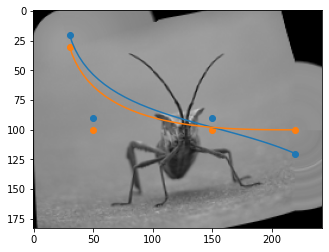

In [105]:
import cv2
import time

from numba import njit

def curveWarp(src, sourceCurve, targetCurve):
    """warp image from source to target with curve coordinates"""
    # create maps
    height, width, channels = src.shape
    mapx = np.zeros( (height, width), dtype=np.float32 )
    mapy = np.zeros( (height, width), dtype=np.float32 )

    # fill stmap
    for i in range(height*width):
        x = i%width
        y = i//width

        u, v = targetCurve.getuv(x, y)
        x1, y1 = sourceCurve.getxy(u, v)

        mapx[y,x] = x1
        mapy[y,x] = y1

    # remap src image
    return cv2.remap(src, mapx.astype(np.float32), mapy.astype(np.float32), cv2.INTER_LINEAR)

# create source curve
cpSrc = np.array( [(30,20),(50,90),(150,90),(220,120)] )
plt.scatter(cpSrc[:,0], cpSrc[:,1])
sourceCurve = Curve(cpSrc[0], cpSrc[1], cpSrc[2], cpSrc[3])
srcPoints = np.array( [sourceCurve.getPoint(t) for t in np.linspace(0,1,32)] )
plt.plot(srcPoints[:,0], srcPoints[:,1])

# create target Curve
cpDst = cpSrc.copy()
cpDst = np.array([(30,30),(50,100),(150,100),(220,100)] )

plt.scatter(cpDst[:,0], cpDst[:,1])
targetCurve = Curve(cpDst[0], cpDst[1], cpDst[2], cpDst[3])
dstPoints = np.array( [targetCurve.getPoint(t) for t in np.linspace(0,1,32)])
plt.plot(dstPoints[:,0], dstPoints[:, 1])

# load image
img = cv2.imread("footage/stinkbug_thumb.png")
timeStart = time.time()
warped = curveWarp(img, sourceCurve, targetCurve)
print(time.time()-timeStart)
plt.imshow(warped)

## Path

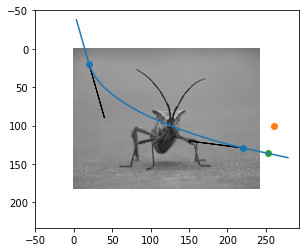

In [174]:
%autoreload
from bezierpath import Path

pathControlPoints = np.array( [
    (30,20),
    (50,90),
    (150,90),
    (220,120)
])

vertices = np.array([
    (20, 20),
    (220, 129)
])
inTangents = np.array([
    (0,0),
    (70, 9)
])
outTangents = np.array([
    (20, 70),
    (0,0)
])

# Plot
fig, ax = plt.subplots()
ax.imshow(img)
ax.set_aspect(1)
ax.set_xlim(-50,img.shape[1]+50)
ax.set_ylim(img.shape[0]+50,-50)
path = Path(vertices, inTangents, outTangents, ax)
path.extend(60)

ax.scatter(vertices[:,0], vertices[:,1])
for p, t in zip(vertices, outTangents):
    ax.arrow(*p, *t, width=0.003)

for p, t in zip(vertices, inTangents):
    ax.arrow(*p, *(-t), width=0.003)

points = np.array([path.getPoint(t) for t in np.linspace(0,1,3*16)])
ax.plot(points[:,0], points[:,1])

P = (260, 100)
ax.scatter(*P)

t = path.getNearestTime(P)
P1 = path.getPoint(t)
plt.scatter(*P1)

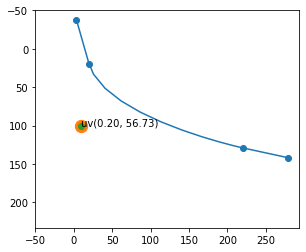

In [244]:
%autoreload
from bezierpath import Curve

fig, ax = plt.subplots()
ax.set_aspect(1)
ax.set_xlim(-50,img.shape[1]+50)
ax.set_ylim(img.shape[0]+50,-50)
cps = np.array( [path.getPoint(t) for t in np.linspace(0,1,4)])
plt.scatter(cps[:,0], cps[:,1])
points = np.array( [path.getPoint(t) for t in np.linspace(0,1,32)] )
ax.plot(points[:,0], points[:,1])

P = (10, 100)
ax.scatter(*P, s=150)
u, v = path.getuv(*P)
ax.annotate( "uv({:.2f}, {:.2f})".format(u, v), P )

x, y = path.getxy(u, v)
ax.scatter(x, y)

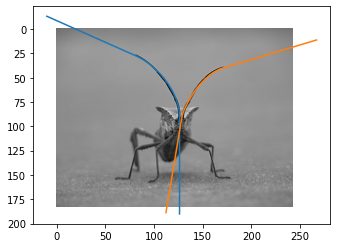

In [340]:
%autoreload
from bezierpath import Path, pathWarp

# load img
img = cv2.imread("./footage/stinkbug_thumb.png")
fig, ax = plt.subplots()
ax.set_aspect(1)
ax.imshow(img)

# create source path
sourcePath = Path(
    vertices=np.array([
        (325, 110),
        (505, 360)
    ])/4,
    inTangents=np.array([
        (0,0),
        (0, 100)
    ])/4,
    outTangents=np.array([
        (90, 40),
        (0,0)
    ])/4
)
sourcePath.extend(100)
sourcePath.plot(ax)

# create target path
targetPath = Path(
    vertices=np.array([
        (685, 160),
        (515, 360)
    ])/4,
    inTangents=np.array([
        (0, 0),
        (-5, 30)
    ])/4,
    outTangents=np.array([
        (-100, 30),
        (0, 0)
    ])/4
)

targetPath.extend(100)
targetPath.plot(ax)

# warp img with paths
warped = pathWarp(img, sourcePath, targetPath)
ax.imshow(warped)
